In [38]:
import sys
import os

project_root = '/home/20230765/src'
if project_root not in sys.path:
    sys.path.append(project_root)
    
from diffusers import AutoPipelineForText2Image, DDIMScheduler
from redi.pipeline_re_sd import ReSDPipeline
import torch
import json
from redi.trajectory import generate_trajectory, save_trajectory, retrieve_nearest_neigbours, generate_trajectory_from_latents
from redi.knowledge_base import create_kb, clean_kb
from metrics.metrics import pick_score, clip_score, fid_score, inception_score
import h5py
import numpy as np
from sklearn.decomposition import PCA
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import faiss
import pandas as pd
import textwrap
from transformers import AutoProcessor, AutoModel
import time
from IPython.display import clear_output

### Trajectories generation

In [ ]:
pipe = AutoPipelineForText2Image.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    variant="fp16")


json_path = "../data/generated_data/prompts/raw_prompts.json"
with open(json_path, "r") as f:
    prompts = json.load(f)

for prompt in tqdm(prompts):
    torch.cuda.empty_cache()
    generation = generate_trajectory(
        prompt=prompt,
        pipeline=pipe,
        device="cuda",
        num_inference_steps=30,
        scheduler=DDIMScheduler
    )
    save_trajectory(
        trajectory=generation[0],
        prompt=generation[1],
        trajectory_filename="../data/generated_data/raw_trajectories",
        prompt_filename="../data/generated_data/raw_prompts",
    )
    del generation

- Ideas to explore - how different are the neigbours with decreasing PCA size
- How differnt are the neighbours if we move key value
- How different are the neighbours if we create more detailed combined keys (like combination of multiple trajectory steps)
- How the quality of generation is affected by the size of KB (if I can have some better size KB)
- Experiment with different schedulers, models (before KB generation)
- Idea of training intermediate model f(key, nearest_neigbours_keys, value) = true value

### Key compression and NN retrieval

In [3]:
key_margin_steps=0
value_margin_steps=20

trajectory_path="../data/generated_data/trajectories.h5"
prompts_from_path="../data/generated_data/prompts.jsonl"

num_trajectories = 2000

np.random.seed(42)
query_set = np.random.choice(
    np.arange(0, num_trajectories), size=200, replace=False
)
key_set = list(set(np.arange(0, num_trajectories)) - set(query_set))


In [4]:
# testing config
config= [
    {
        "use_pca": True,
        "embedding_dim": 2,
        "use_pq": False,
    },
    {
        "use_pca": True,
        "embedding_dim": 4,
        "use_pq": False,
    },
    {
        "use_pca": True,
        "embedding_dim": 16,
        "use_pq": False,
    },
    {
        "use_pca": True,
        "embedding_dim": 64,
        "use_pq": False,
    },
    {
        "use_pca": True,
        "embedding_dim": 256,
        "use_pq": False,
    },
    {
        "use_pq": True,
        "n_pq_subvectors": 8,
        "n_pq_centroids": 32,
    },
    {
        "use_pq": True,
        "n_pq_subvectors": 16,
        "n_pq_centroids": 32,
    },
    {
        "use_pq": True,
        "n_pq_subvectors": 32,
        "n_pq_centroids": 32,
    },
    {
        "use_pq": True,
        "n_pq_subvectors": 64,
        "n_pq_centroids": 32,
    },
    {
        "use_pca": True,
        "embedding_dim": 64,
        "use_pq": True,
        "n_pq_subvectors": 8,
        "n_pq_centroids": 32,
    },
    {
        "use_pca": True,
        "embedding_dim": 64,
        "use_pq": True,
        "n_pq_subvectors": 16,
        "n_pq_centroids": 32,
    },
    {
        "use_pca": True,
        "embedding_dim": 64,
        "use_pq": True,
        "n_pq_subvectors": 64,
        "n_pq_centroids": 32,
    },
]

#### Reference KB

In [5]:
kb_path="../data/reference_knowledge_base/knowledge_base.h5"
faiss_index_path="../data/reference_knowledge_base/faiss_index.bin"
prompts_to_path="../data/reference_knowledge_base/prompts.json"

In [15]:
# clean_kb(
#         kb_path=kb_path,
#         faiss_index_path=faiss_index_path,
#         prompts_path=prompts_to_path,
#     )

In [12]:
create_kb(
    key_margin_steps=key_margin_steps,
    value_margin_steps=value_margin_steps,
    trajectory_path=trajectory_path,
    kb_path=kb_path,
    faiss_index_path=faiss_index_path,
    prompts_from_path=prompts_from_path,
    prompts_to_path=prompts_to_path,
)

0it [00:00, ?it/s]

2000it [04:16,  7.79it/s]


In [ ]:
reference_times = []
for i in range(10):
    with h5py.File(trajectory_path, "r") as trajectory_file:
        traj_names = list(trajectory_file.keys())
        reference_neighbours_list = []
        reference_time = 0
        for query in tqdm(query_set):
            query = trajectory_file[traj_names[query]][key_margin_steps]
            neighbours, time = retrieve_nearest_neigbours(
                query_array=query,
                num_neighbours=11,
                index_path=faiss_index_path,
                kb_path=kb_path
            )    
            reference_neighbours_list.append([int(neighbour[2]) for neighbour in neighbours][1:])
            reference_time += time
    reference_time /= len(query_set)
    reference_times.append(reference_time)
reference_times

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

[0.009157599210739135,
 0.009516289234161377,
 0.009406523704528809,
 0.009603971242904663,
 0.009361915588378907,
 0.009333226680755615,
 0.009330482482910156,
 0.008988490104675293,
 0.009757686853408814,
 0.009790719747543334]

#### KB testing

In [5]:
kb_path="../data/knowledge_base/knowledge_base.h5"
faiss_index_path="../data/knowledge_base/faiss_index.bin"
prompts_to_path="../data/knowledge_base/prompts.json"

use_pca = True
pca_path="../data/knowledge_base/compression.pkl"

In [ ]:
dim_neighbours = []
avg_times = []
for cfg in tqdm(config):
    create_kb(
        key_margin_steps=key_margin_steps,
        value_margin_steps=value_margin_steps,
        trajectory_path=trajectory_path,
        kb_path=kb_path,
        faiss_index_path=faiss_index_path,
        prompts_from_path=prompts_from_path,
        prompts_to_path=prompts_to_path,
        pca_path=pca_path,
        **cfg,
        
    )
    # clean queries
    with h5py.File(kb_path, "a") as kb_file:
        for query in query_set:
            del kb_file[str(query)]
            
    #remove ids
    index = faiss.read_index(faiss_index_path)
    index.remove_ids(query_set)
    faiss.write_index(index, faiss_index_path)
    
    
    
    # find neigbours
    avg_times_list = []
    for i in range(10):
        neighbours_list = []
        timing = 0
        with h5py.File(trajectory_path, "r") as trajectory_file:
            traj_names = list(trajectory_file.keys())
            for query in tqdm(query_set):
                query = trajectory_file[traj_names[query]][key_margin_steps]
                if "use_pca" in cfg.keys() and cfg["use_pca"] == True:
                    pca = pickle.load(open(pca_path, "rb"))
                    start_pca = time.time()
                    query = pca.transform(query.reshape(1, -1)).squeeze()
                    end_pca = time.time()
                    elapsed_pca = end_pca - start_pca
                    timing += elapsed_pca
                neighbours, time_search = retrieve_nearest_neigbours(
                    query_array=query,
                    num_neighbours=10,
                    index_path=faiss_index_path,
                    kb_path=kb_path
                )
                neighbours_list.append([int(neighbour[2]) for neighbour in neighbours])
                timing += time_search
        avg_times_list.append(timing / len(query_set))
    avg_times.append(avg_times_list)
    dim_neighbours.append(neighbours_list)
    
    clean_kb(
        kb_path=kb_path,
        faiss_index_path=faiss_index_path,
        prompts_path=prompts_to_path,
        compression_path=pca_path if "use_pca" in cfg.keys() and cfg["use_pca"] ==True else None,
    )


  0%|          | 0/12 [00:00<?, ?it/s]

Fitting PCA...


2000it [00:02, 810.86it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl
Fitting PCA...


2000it [00:03, 617.17it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl
Fitting PCA...


2000it [00:03, 637.05it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl
Fitting PCA...


2000it [00:05, 368.61it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl
Fitting PCA...


2000it [00:16, 123.84it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl
Training PQ index...


2000it [00:50, 39.68it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, None
Training PQ index...


2000it [00:52, 38.37it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, None
Training PQ index...


2000it [00:53, 37.59it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, None
Training PQ index...


2000it [00:55, 35.85it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, None
Fitting PCA...
Training PQ index...


2000it [00:07, 256.73it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl
Fitting PCA...
Training PQ index...


2000it [00:07, 263.19it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl
Fitting PCA...
Training PQ index...


2000it [00:05, 337.47it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl


In [ ]:
dim_neighbours.append(reference_neighbours_list)
avg_times.append(reference_times)

/tmp/ipykernel_2800480/1764953629.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


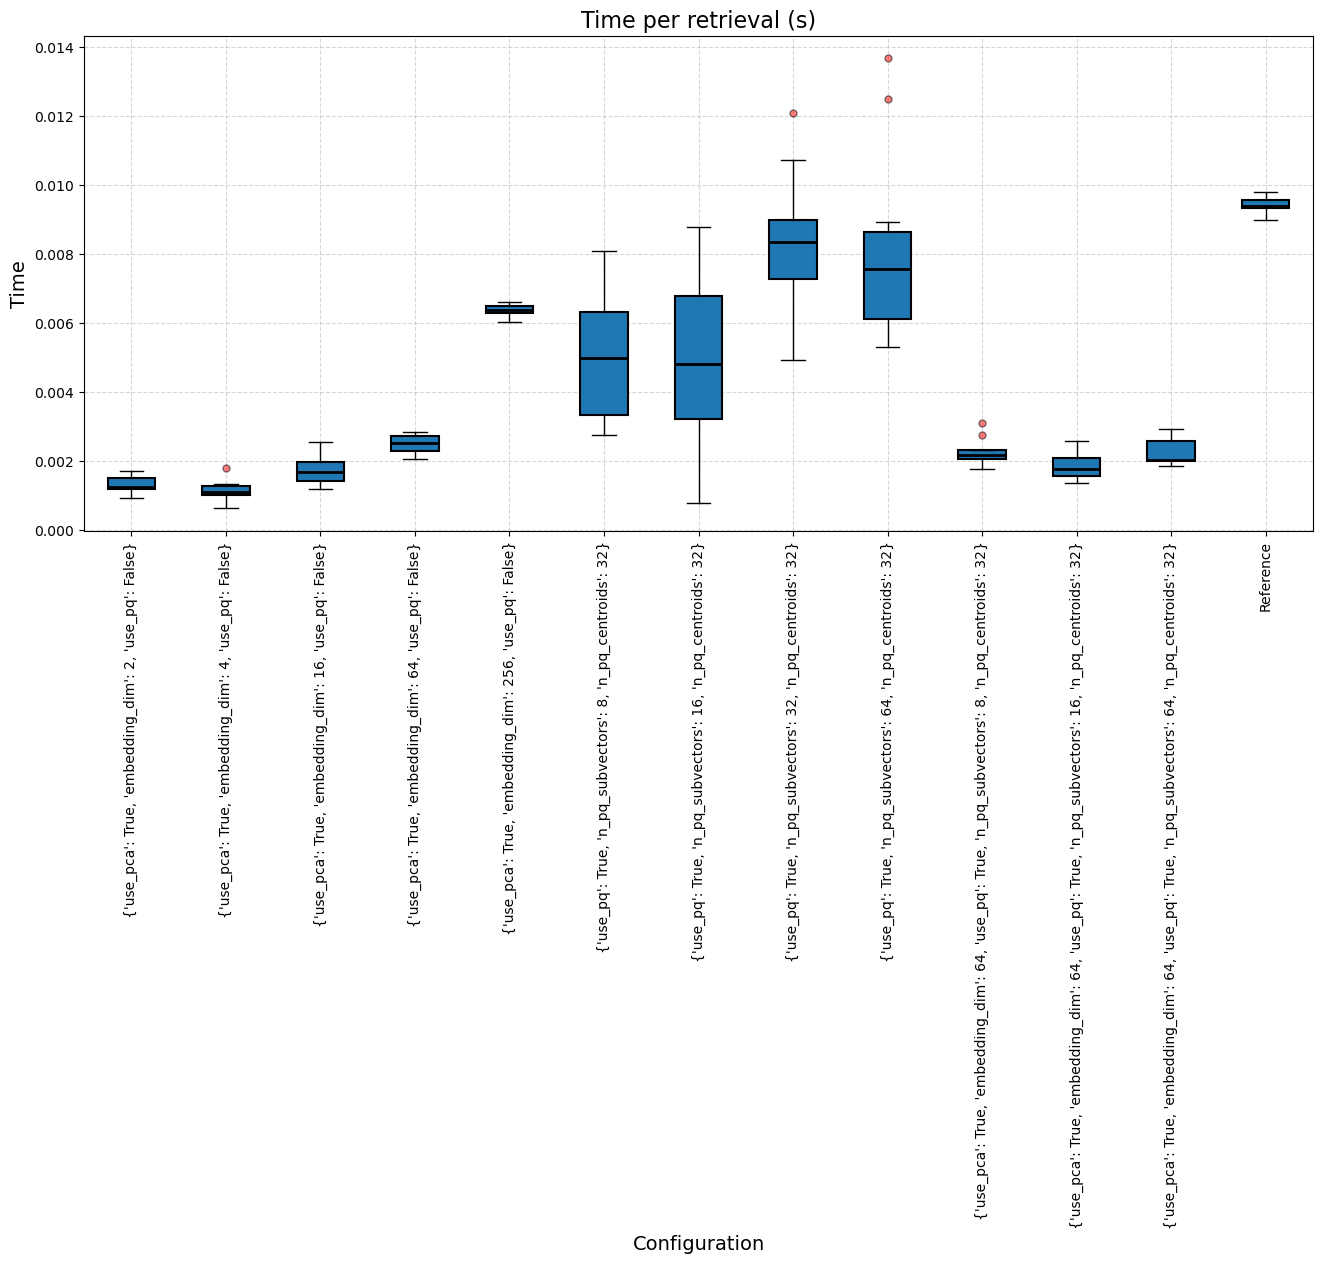

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))

# Create boxplot
box = ax.boxplot(
    avg_times,
    labels=[str(config[i]) for i in range(len(config))] + ["Reference"],
    patch_artist=True,   # This is important for color filling
    medianprops=dict(color="black", linewidth=2),
    boxprops=dict(edgecolor="black", linewidth=1.5),
    whiskerprops=dict(color="black", linewidth=1),
    capprops=dict(color="black", linewidth=1),
    flierprops=dict(markerfacecolor="red", marker="o", markersize=5, alpha=0.5)
)

# Plot settings
plt.title("Time per retrieval (s)", fontsize=16)
plt.xlabel("Configuration", fontsize=14)
plt.ylabel("Time", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()


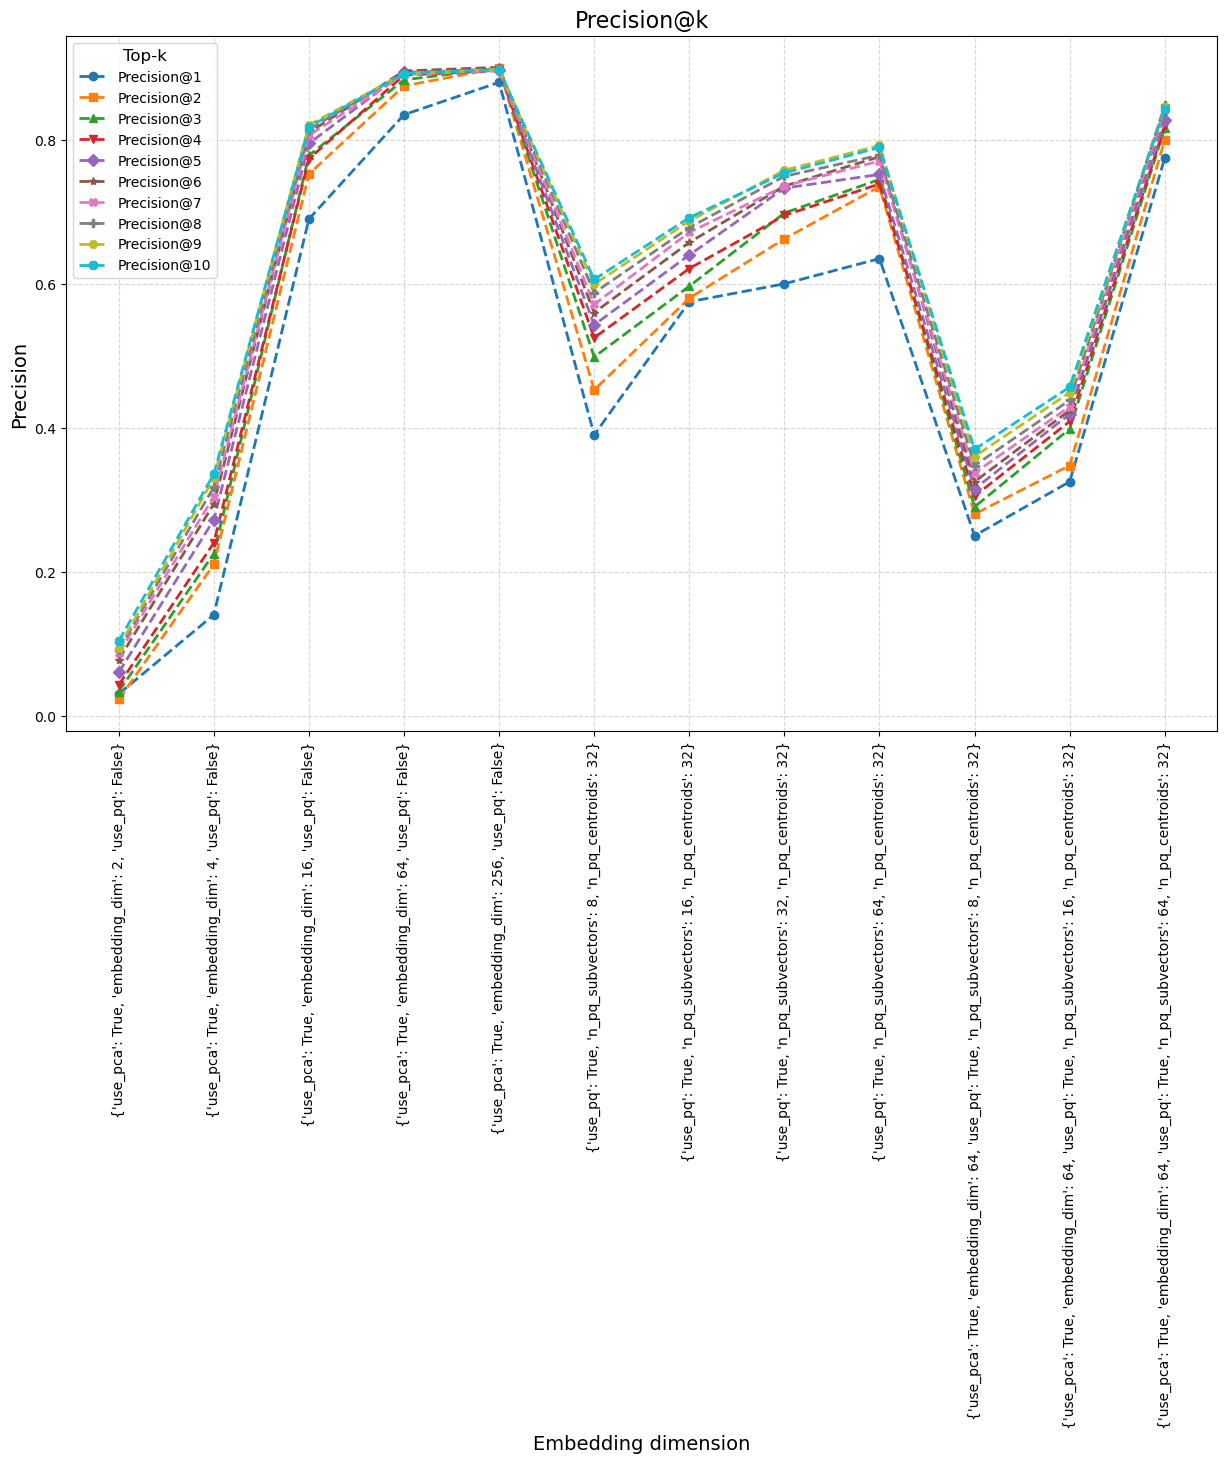

In [ ]:

plt.figure(figsize=(16, 8))
markers = ['o', 's', '^', 'v', 'D', '*', 'X', 'P', 'H', '8']

precision_table = {} 

for k in range(1, 11):
    precision_at_k = np.zeros(len(dim_neighbours)-1)
    for i in range(len(query_set)):
        neighbours_comparison = [dim[i] for dim in dim_neighbours]
        for j in range(len(neighbours_comparison)-1):
            precision_at_k[j] += len(set(neighbours_comparison[j][:k]) & set(neighbours_comparison[-1][:k])) / k

    precision_values = precision_at_k / len(query_set)

    precision_table[f"Precision@{k}"] = precision_values
    plt.plot(
        [str(config[i]) for i in range(len(config))],
        precision_values,
        marker=markers[k-1],
        linestyle='--',
        linewidth=2,
        label=f"Precision@{k}"
    )

# Plot settings
plt.title("Precision@k", fontsize=16)
plt.xlabel("Embedding dimension", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Top-k", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.xticks(rotation=90)  # Rotate 60 degrees

plt.show()

precision_df = pd.DataFrame(precision_table, index=[str(config[i]) for i in range(len(config))])



In [ ]:
# Time df
df = pd.DataFrame(
    {
        "Time (s)": avg_times,
        "Configuration": [str(config[i]) for i in range(len(config))] + ["Reference"]
    }
).round(5)
df = df.set_index("Configuration")
df.to_csv("../data/results/time_key-margin=0_dataset-size=2000.csv")

In [ ]:
import ast
df = pd.read_csv("../data/results/time_key-margin=0_dataset-size=20001.csv")
df["Time (s)"].apply(ast.literal_eval)[0]

[0.0012621724605560304,
 0.0012381160259246826,
 0.0009407877922058105,
 0.0017220425605773927,
 0.0012369096279144288,
 0.0016003131866455078,
 0.001263587474822998,
 0.0016861677169799805,
 0.0011851513385772706,
 0.0009835278987884522]

In [ ]:
precision_df.to_csv("../data/results/precision@k_key-margin=0_dataset-size=2000.csv")

In [ ]:
with open("../data/results/neighbours_key-margin=0_dataset-size=2000.json", "w") as f:
    json.dump(dim_neighbours, f, indent=4)


### Generation from retrieved

In [6]:
prompts = json.load(open(prompts_to_path, "r"))
pipe = ReSDPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16
).to("cuda:1")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
with open("../data/results/neighbours_key-margin=0_dataset-size=2000.json") as f:
    dim_neighbours = json.load(f)

In [8]:
with h5py.File(trajectory_path, "r") as trajectory_file:
    traj_names = list(trajectory_file.keys())

In [67]:
value_margin_steps = 20
config_index = 3
query_index = 109
neighbour_num = 0

In [68]:
neighbours = dim_neighbours[config_index][query_index]
with h5py.File(trajectory_path, "r") as trajectory_file:
    neighbour_latent = trajectory_file[traj_names[neighbours[neighbour_num]]][-value_margin_steps]
    last_real_latent = trajectory_file[traj_names[query_set[query_index]]][-1]
    last_neighbour_latent = trajectory_file[traj_names[neighbours[neighbour_num]]][-1]


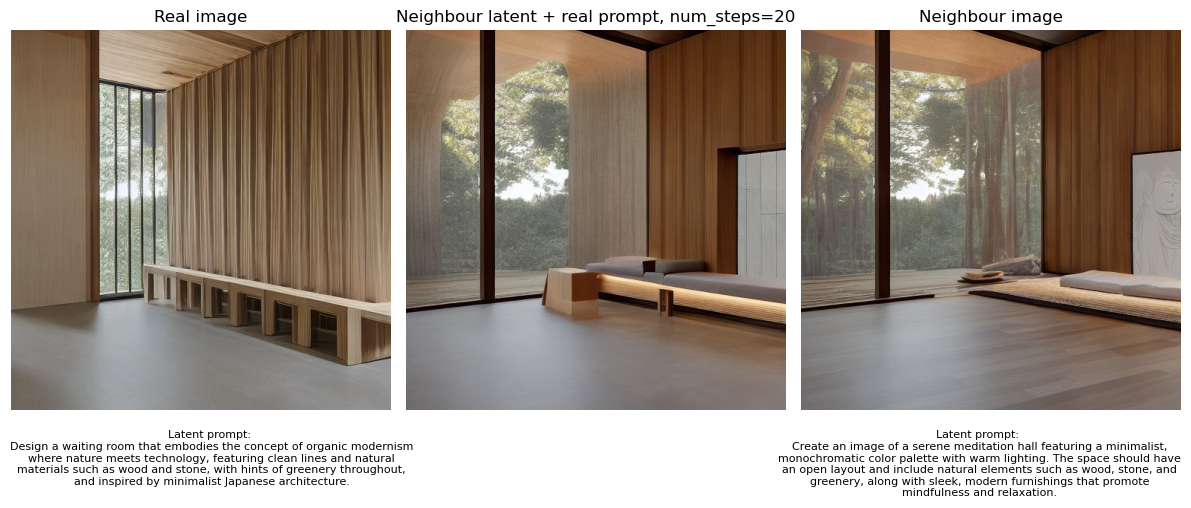

In [70]:
img_real = pipe.decode_latent_to_image(
    latent=last_real_latent,
)

img_neighbour = pipe.decode_latent_to_image(
    latent=last_neighbour_latent,
)

img_real_from_neighbour = generate_trajectory_from_latents(
    prompt=prompts[str(query_set[query_index])],
    latent=neighbour_latent,
    device="cuda",
    num_inference_steps=30,
    value_margin_steps=value_margin_steps,
    scheduler=DDIMScheduler,
    pipeline=pipe
)[0]

#show both and prompt
clear_output()
fig, ax = plt.subplots(ncols = 3, figsize=(12, 5))
prompt = prompts[str(query_set[query_index])]
ax[1].imshow(img_real_from_neighbour)
ax[1].set_title(f"Neighbour latent + real prompt, num_steps={value_margin_steps}")
ax[0].imshow(img_real)
ax[0].set_title(f"Real image")
ax[2].imshow(img_neighbour)
ax[2].set_title(f"Neighbour image")

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

# Prepare wrapped prompts
real_prompt = "Latent prompt: \n" + "\n".join(textwrap.wrap(prompts[str(query_set[query_index])], width=70))
neighbour_prompt = "Latent prompt: \n" + "\n".join(textwrap.wrap(prompts[str(neighbours[neighbour_num])], width=70))

# Put wrapped prompts **below** each image
fig.text(0.18, 0.08, real_prompt, ha='center', va='top', fontsize=8)
fig.text(0.82, 0.08, neighbour_prompt, ha='center', va='top', fontsize=8)

plt.tight_layout()


plt.show()


#### Different value_margin_steps

In [71]:
value_margin_steps = 25
config_index = 3
neighbour_num = 0

In [ ]:
clips_real = []
clips_generated = []
picks = []
inceptions_real = []
inceptions_generated = []
fids = []
for value_margin_steps in tqdm([15, 20, 25, 27]):
    resulting_images = []
    pick = 0
    for query_index in tqdm(range(len(query_set))):
        neighbours = dim_neighbours[config_index][query_index]
        with h5py.File(trajectory_path, "r") as trajectory_file:
            neighbour_latent = trajectory_file[traj_names[neighbours[neighbour_num]]][-value_margin_steps]
            last_real_latent = trajectory_file[traj_names[query_set[query_index]]][-1]
            
        prompt = prompts[str(query_set[query_index])]


        img_real = pipe.decode_latent_to_image(
            latent=last_real_latent,
        )

        img_real_from_neighbour = generate_trajectory_from_latents(
            prompt=prompt,
            latent=neighbour_latent,
            device="cuda",
            num_inference_steps=30,
            value_margin_steps=value_margin_steps,
            scheduler=DDIMScheduler,
            pipeline=pipe
        )[0]
        resulting_images.append([img_real_from_neighbour, 
                                 img_real
                                 ]
                                )
        
        # #metrics
        pick += pick_score(
            prompt=prompt,
            images = [img_real_from_neighbour, img_real],
        )[0]  
    real_images = [images[1] for images in resulting_images]
    generated_images = [images[0] for images in resulting_images]

    clip_real = clip_score(
        images=np.array(real_images),
        prompts=[prompts[str(query_set[i])] for i in range(len(query_set))],
    )
    clip_generated = clip_score(
        images=np.array(generated_images),
        prompts=[prompts[str(query_set[i])] for i in range(len(query_set))],
    )

    fid = fid_score(
        real_images=real_images,
        generated_images=generated_images,
    )

    inception_real = inception_score(images=real_images)
    inception_generated = inception_score(images=generated_images)

    print("FID: ", fid)
    print("Inception score real: ", inception_real)
    print("Inception score generated: ", inception_generated)
    print("CLIP score real: ", clip_real)
    print("CLIP score generated: ", clip_generated)
    print("Pick score: ", pick/(query_index+1))
    
    fids.append(fid)
    inceptions_real.append(inception_real)
    inceptions_generated.append(inception_generated)
    clips_real.append(clip_real)
    clips_generated.append(clip_generated)
    picks.append(pick/(query_index+1))


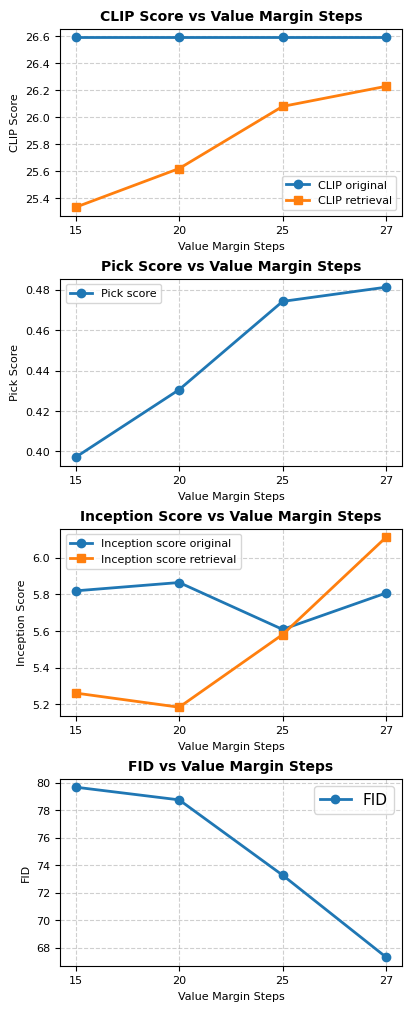

In [ ]:
fig, ax = plt.subplots(nrows=4, figsize=(4, 10), dpi=100, constrained_layout=True)

# Define common properties
colors = ['#1f77b4', '#ff7f0e']
markers = ['o', 's']

labels = ["15", "20", "25", "27"]

# CLIP score
ax[0].plot(
    labels,
    clips_real,
    marker=markers[0],
    linestyle='-',
    linewidth=2,
    color=colors[0],
    label="CLIP original"
)
ax[0].plot(
    labels,
    clips_generated,
    marker=markers[1],
    linestyle='-',
    linewidth=2,
    color=colors[1],
    label="CLIP retrieval"
)
ax[0].set_title("CLIP Score vs Value Margin Steps", fontsize=10, fontweight='bold')
ax[0].legend(fontsize=8)
ax[0].set_xlabel("Value Margin Steps", fontsize=8)
ax[0].set_ylabel("CLIP Score", fontsize=8)
ax[0].grid(True, linestyle='--', alpha=0.6)

# Pick score
ax[1].plot(
    labels,
    picks,
    marker='o',
    linestyle='-',
    linewidth=2,
    color=colors[0],
    label="Pick score"
)
ax[1].set_title("Pick Score vs Value Margin Steps", fontsize=10, fontweight='bold')
ax[1].set_xlabel("Value Margin Steps", fontsize=8)
ax[1].set_ylabel("Pick Score", fontsize=8)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].legend(fontsize=8)

# Inception score
ax[2].plot(
    labels,
    inceptions_real,
    marker='o',
    linestyle='-',
    linewidth=2,
    color=colors[0],
    label="Inception score original"
)
ax[2].plot(
    labels,
    inceptions_generated,
    marker='s',
    linestyle='-',
    linewidth=2,
    color=colors[1],
    label="Inception score retrieval"
)
ax[2].set_title("Inception Score vs Value Margin Steps", fontsize=10, fontweight='bold')
ax[2].set_xlabel("Value Margin Steps", fontsize=8)
ax[2].set_ylabel("Inception Score", fontsize=8)
ax[2].grid(True, linestyle='--', alpha=0.6)
ax[2].legend(fontsize=8)

# FID
ax[3].plot(
    labels,
    fids,
    marker='o',
    linestyle='-',
    linewidth=2,
    color= colors[0],
    label="FID"
)
ax[3].set_title("FID vs Value Margin Steps", fontsize=10, fontweight='bold')
ax[3].set_xlabel("Value Margin Steps", fontsize=8)
ax[3].set_ylabel("FID", fontsize=8)
ax[3].grid(True, linestyle='--', alpha=0.6)
ax[3].legend(fontsize=11)

for axis in ax:
    axis.tick_params(axis='both', labelsize=8)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontname('DejaVu Sans')
        label.set_fontsize(8)

plt.show()

In [ ]:
# Create DataFrame with metrics
metrics_df = pd.DataFrame({
    'Value Margin Steps': [15, 20, 25, 27],
    'CLIP Score (Original)': clips_real,
    'CLIP Score (Retrieval)': clips_generated,
    'Pick Score': picks,
    'Inception Score (Original)': inceptions_real,
    'Inception Score (Retrieval)': inceptions_generated,
    'FID Score': fids
})

# Set Value Margin Steps as index
metrics_df = metrics_df.set_index('Value Margin Steps')

# # Save to CSV
metrics_df.to_csv('../data/results/metrics-value-margin-steps_key-margin=0_dataset-size=2000_num-neighbours=1.csv')

# Display the table
metrics_df

,CLIP Score (Original),CLIP Score (Retrieval),Pick Score,Inception Score (Original),Inception Score (Retrieval),FID Score
Value Margin Steps,,,,,,
15,26.5914,25.3321,0.397067,5.818659,5.261682,79.666824
20,26.5914,25.6188,0.430543,5.864050,5.184514,78.743507
25,26.5914,26.0787,0.474252,5.608486,5.580770,73.267616
27,26.5914,26.2277,0.481297,5.806905,6.111145,67.306961


#### Different amount of neighbours

In [124]:
value_margin_steps = 25
config_index = 3
neighbour_num = 9

In [ ]:
clips_real = []
clips_generated = []
picks = []
inceptions_real = []
inceptions_generated = []
fids = []
for neighbour_num in tqdm([0, 2, 4, 9]):
    resulting_images = []
    pick = 0
    for query_index in tqdm(range(len(query_set))):
        neighbours = dim_neighbours[config_index][query_index]
        with h5py.File(trajectory_path, "r") as trajectory_file:
            neighbours_latents = [
                trajectory_file[traj_names[neighbours[j]]][-value_margin_steps]
                for j in range(neighbour_num + 1)
            ]
            neighbour_latent = np.mean(neighbours_latents, axis=0)
            
            last_real_latent = trajectory_file[traj_names[query_set[query_index]]][-1]
            
        prompt = prompts[str(query_set[query_index])]


        img_real = pipe.decode_latent_to_image(
            latent=last_real_latent,
        )

        img_real_from_neighbour = generate_trajectory_from_latents(
            prompt=prompt,
            latent=neighbour_latent,
            device="cuda",
            num_inference_steps=30,
            value_margin_steps=value_margin_steps,
            scheduler=DDIMScheduler,
            pipeline=pipe
        )[0]
        resulting_images.append([img_real_from_neighbour, 
                                 img_real, 
                                #  img_neighbour
                                 ]
                                )
        
        # #metrics
        pick += pick_score(
            prompt=prompt,
            images = [img_real_from_neighbour, img_real],
        )[0]  
    real_images = [images[1] for images in resulting_images]
    generated_images = [images[0] for images in resulting_images]

    clip_real = clip_score(
        images=np.array(real_images),
        prompts=[prompts[str(query_set[i])] for i in range(len(query_set))],
    )
    clip_generated = clip_score(
        images=np.array(generated_images),
        prompts=[prompts[str(query_set[i])] for i in range(len(query_set))],
    )

    fid = fid_score(
        real_images=real_images,
        generated_images=generated_images,
    )

    inception_real = inception_score(images=real_images)
    inception_generated = inception_score(images=generated_images)

    print("FID: ", fid)
    print("Inception score real: ", inception_real)
    print("Inception score generated: ", inception_generated)
    print("CLIP score real: ", clip_real)
    print("CLIP score generated: ", clip_generated)
    print("Pick score: ", pick/(query_index+1))
    
    fids.append(fid)
    inceptions_real.append(inception_real)
    inceptions_generated.append(inception_generated)
    clips_real.append(clip_real)
    clips_generated.append(clip_generated)
    picks.append(pick/(query_index+1))


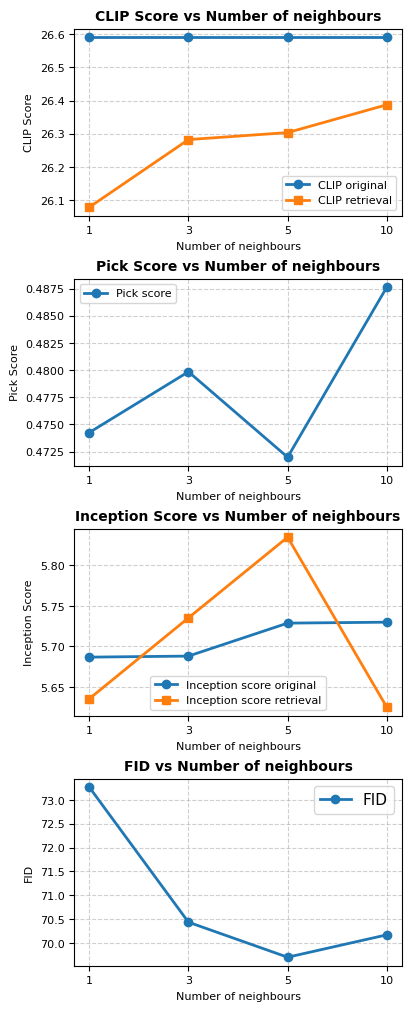

In [128]:
fig, ax = plt.subplots(nrows=4, figsize=(4, 10), dpi=100, constrained_layout=True)

# Define common properties
colors = ['#1f77b4', '#ff7f0e']
markers = ['o', 's']

labels = ['1', '3', '5', '10']

# CLIP score
ax[0].plot(
    labels,
    clips_real,
    marker=markers[0],
    linestyle='-',
    linewidth=2,
    color=colors[0],
    label="CLIP original"
)
ax[0].plot(
    labels,
    clips_generated,
    marker=markers[1],
    linestyle='-',
    linewidth=2,
    color=colors[1],
    label="CLIP retrieval"
)
ax[0].set_title("CLIP Score vs Number of neighbours", fontsize=10, fontweight='bold')
ax[0].legend(fontsize=8)
ax[0].set_xlabel("Number of neighbours", fontsize=8)
ax[0].set_ylabel("CLIP Score", fontsize=8)
ax[0].grid(True, linestyle='--', alpha=0.6)

# Pick score
ax[1].plot(
    labels,
    picks,
    marker='o',
    linestyle='-',
    linewidth=2,
    color=colors[0],
    label="Pick score"
)
ax[1].set_title("Pick Score vs Number of neighbours", fontsize=10, fontweight='bold')
ax[1].set_xlabel("Number of neighbours", fontsize=8)
ax[1].set_ylabel("Pick Score", fontsize=8)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].legend(fontsize=8)

# Inception score
ax[2].plot(
    labels,
    inceptions_real,
    marker='o',
    linestyle='-',
    linewidth=2,
    color=colors[0],
    label="Inception score original"
)
ax[2].plot(
    labels,
    inceptions_generated,
    marker='s',
    linestyle='-',
    linewidth=2,
    color=colors[1],
    label="Inception score retrieval"
)
ax[2].set_title("Inception Score vs Number of neighbours", fontsize=10, fontweight='bold')
ax[2].set_xlabel("Number of neighbours", fontsize=8)
ax[2].set_ylabel("Inception Score", fontsize=8)
ax[2].grid(True, linestyle='--', alpha=0.6)
ax[2].legend(fontsize=8)

# FID
ax[3].plot(
    labels,
    fids,
    marker='o',
    linestyle='-',
    linewidth=2,
    color= colors[0],
    label="FID"
)
ax[3].set_title("FID vs Number of neighbours", fontsize=10, fontweight='bold')
ax[3].set_xlabel("Number of neighbours", fontsize=8)
ax[3].set_ylabel("FID", fontsize=8)
ax[3].grid(True, linestyle='--', alpha=0.6)
ax[3].legend(fontsize=11)

for axis in ax:
    axis.tick_params(axis='both', labelsize=8)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontname('DejaVu Sans')
        label.set_fontsize(8)

plt.show()

In [129]:
# Create DataFrame with metrics
metrics_df = pd.DataFrame({
    'Value Margin Steps': [15, 20, 25, 27],
    'CLIP Score (Original)': clips_real,
    'CLIP Score (Retrieval)': clips_generated,
    'Pick Score': picks,
    'Inception Score (Original)': inceptions_real,
    'Inception Score (Retrieval)': inceptions_generated,
    'FID Score': fids
})

# Set Value Margin Steps as index
metrics_df = metrics_df.set_index('Value Margin Steps')

# # Save to CSV
metrics_df.to_csv('../data/results/metrics-num-neighbours_key-margin=0_dataset-size=2000_value-margin-steps=25.csv')

# Display the table
metrics_df

,CLIP Score (Original),CLIP Score (Retrieval),Pick Score,Inception Score (Original),Inception Score (Retrieval),FID Score
Value Margin Steps,,,,,,
15,26.5914,26.0787,0.474252,5.686778,5.635351,73.267616
20,26.5914,26.2826,0.479848,5.688065,5.735252,70.434608
25,26.5914,26.3037,0.471980,5.728769,5.834896,69.699646
27,26.5914,26.3876,0.487634,5.729929,5.624936,70.169182


### Metrics

In [27]:
pick_score(prompt = prompt,
           images = [img_real, 
                    #  img_neighbour, 
                     img_real_from_neighbour])

[0.5769102573394775, 0.42308974266052246]

In [28]:
clip_score(prompt = prompt,
           images = [img_real, img_neighbour, img_real_from_neighbour])

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


[20.19230842590332, 20.081932067871094, 20.160140991210938]

In [35]:
fid_score(
    real_images=real_images,
    generated_images=generated_images,
)

201.53268432617188

In [40]:
inception_score(
images=generated_images
)

/home/20230765/.local/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


1.0

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").cuda()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

def compute_clip_score(image: Image.Image, prompt: str):
    inputs = processor(text=[prompt], images=image, return_tensors="pt", padding=True).to("cuda")
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # raw cosine similarity
    cosine_similarity = logits_per_image[0, 0] / model.logit_scale.exp()  # correct unscaling

    clip_score = (cosine_similarity + 1) / 2
    return clip_score.item()


In [ ]:
print(compute_clip_score(
    img_real_from_neighbour,
    prompts[str(query_set[query_index])]
), )
print(compute_clip_score(
    img_real,
    prompts[str(query_set[query_index])]
))

0.6431111693382263
0.6505122184753418


#### Pick Score

In [ ]:
# import
from transformers import AutoProcessor, AutoModel

# load model
device = "cuda"
processor_name_or_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
model_pretrained_name_or_path = "yuvalkirstain/PickScore_v1"

processor = AutoProcessor.from_pretrained(processor_name_or_path)
model = AutoModel.from_pretrained(model_pretrained_name_or_path).eval().to(device)

def calc_probs(prompt, images):
    
    # preprocess
    image_inputs = processor(
        images=images,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)
    
    text_inputs = processor(
        text=prompt,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)


    with torch.no_grad():
        # embed
        image_embs = model.get_image_features(**image_inputs)
        image_embs = image_embs / torch.norm(image_embs, dim=-1, keepdim=True)
    
        text_embs = model.get_text_features(**text_inputs)
        text_embs = text_embs / torch.norm(text_embs, dim=-1, keepdim=True)
    
        # score
        scores = model.logit_scale.exp() * (text_embs @ image_embs.T)[0]
        
        # get probabilities if you have multiple images to choose from
        probs = torch.softmax(scores, dim=-1)
    
    return probs.cpu().tolist()


In [ ]:
calc_probs(
    prompts[str(query_set[query_index])],
    [img_real_from_neighbour, img_real, img_neighbour]
)

[0.3799605071544647, 0.522676408290863, 0.09736309945583344]

In [ ]:
print(compute_pickscore(img_real_from_neighbour,
    prompts[str(query_set[query_index])]))
print(compute_pickscore(img_real,
    prompts[str(query_set[query_index])]))

20.674680709838867
20.942581176757812


  0%|          | 0/20 [00:00<?, ?it/s]

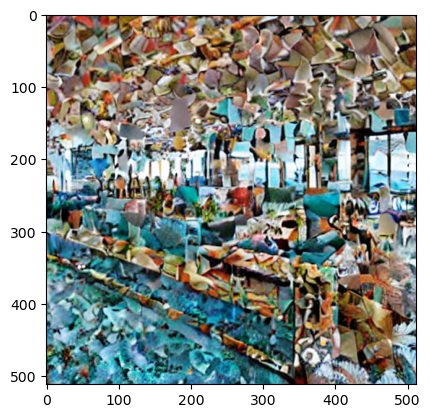

In [ ]:
img = generate_trajectory_from_latents(
    prompt=prompts[neighbours[0][2]],
    latent=latent,
    device="cuda",
    num_inference_steps=30-10,
    value_margin_steps=value_margin_steps-10,
    scheduler=DDIMScheduler,
    pipeline=pipe
)
plt.imshow(img)

  0%|          | 0/2 [00:00<?, ?it/s]

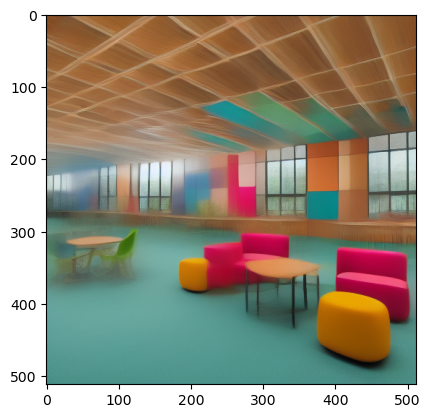

In [ ]:
# real
latent = neighbours[0][0] 

img = generate_trajectory_from_latents(
    prompt=prompt,
    latent=latent,
    device="cuda",
    num_inference_steps=20,
    value_margin_steps=20,
    scheduler=DDIMScheduler,
    pipeline=pipe
)

plt.imshow(img)